In [73]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from fastai.imports import *
import tensorflow as tf

In [74]:
df = pd.read_csv('RELIANCE.NS.csv',parse_dates = ['Date'] )
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0
1,2000-01-04,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0
2,2000-01-05,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0
3,2000-01-06,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0
4,2000-01-07,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0


In [75]:
def add_datepart(df, fldname, drop=False):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())    
        df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [76]:
add_datepart(df,'Date')

<ipython-input-75-78961096a606>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[targ_pre+n] = getattr(fld.dt,n.lower())


In [77]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Elapsed,Month,Week,Day
0,2000-01-03,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0,2000,946857600,1,1,3
1,2000-01-04,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0,2000,946944000,1,1,4
2,2000-01-05,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0,2000,947030400,1,1,5
3,2000-01-06,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0,2000,947116800,1,1,6
4,2000-01-07,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0,2000,947203200,1,1,7


In [78]:
df = df.fillna(method = 'pad')


In [79]:
series1 = df.iloc[:,4]

In [80]:
series1

0         38.944569
1         42.062302
2         43.710136
3         45.543640
4         48.669109
           ...     
5353    1985.650024
5354    1963.150024
5355    1970.050049
5356    1976.099976
5357    2094.800049
Name: Close, Length: 5358, dtype: float64

In [81]:
series2 = df.iloc[:,0]
series2

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5353   2021-05-24
5354   2021-05-25
5355   2021-05-26
5356   2021-05-27
5357   2021-05-28
Name: Date, Length: 5358, dtype: datetime64[ns]

In [82]:
split_time = 4760
x_train = series[:split_time]
x_valid = series[split_time:]

In [83]:
x_train

0         38.944569
1         42.062302
2         43.710136
3         45.543640
4         48.669109
           ...     
4755    1119.290283
4756    1125.729248
4757    1126.125488
4758    1117.853882
4759    1089.869141
Name: Close, Length: 4760, dtype: float64

In [84]:
x_valid

4760    1078.922852
4761    1088.036499
4762    1109.681274
4763    1114.981079
4764    1110.721436
           ...     
5353    1985.650024
5354    1963.150024
5355    1970.050049
5356    1976.099976
5357    2094.800049
Name: Close, Length: 598, dtype: float64

In [85]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [86]:
moving_avg = moving_average_forecast(series1, 30)[split_time - 30:]

In [87]:
time_train = series2[:split_time]
time_valid = series2[split_time:]


In [88]:
time_valid

4760   2018-12-24
4761   2018-12-26
4762   2018-12-27
4763   2018-12-28
4764   2018-12-31
          ...    
5353   2021-05-24
5354   2021-05-25
5355   2021-05-26
5356   2021-05-27
5357   2021-05-28
Name: Date, Length: 598, dtype: datetime64[ns]

In [89]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

In [90]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

83.62545820423632

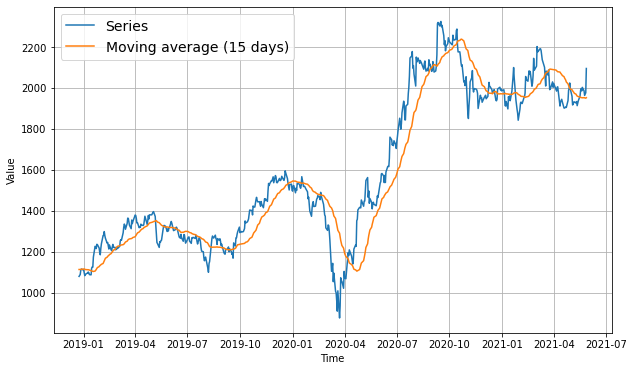

In [93]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (15 days)")


In [96]:
df['first_closediff'] = df['Close'] - df['Close'].shift(1)

In [97]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Elapsed,Month,Week,Day,first_closediff
0,2000-01-03,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0,2000,946857600,1,1,3,NaN
1,2000-01-04,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0,2000,946944000,1,1,4,3.117733
2,2000-01-05,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0,2000,947030400,1,1,5,1.647834
3,2000-01-06,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0,2000,947116800,1,1,6,1.833504
4,2000-01-07,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0,2000,947203200,1,1,7,3.125469


In [98]:
df = df.drop(['Date','Month','Week','Day','Year'],axis = 1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Elapsed,first_closediff
0,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0,946857600,NaN
1,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0,946944000,3.117733
2,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0,947030400,1.647834
3,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0,947116800,1.833504
4,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0,947203200,3.125469


In [99]:
df = df.fillna(0)

In [100]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Elapsed,first_closediff
0,36.747459,38.944569,36.747459,38.944569,29.869350,28802010.0,946857600,0.000000
1,39.981236,42.062302,38.882679,42.062302,32.260563,61320457.0,946944000,3.117733
2,39.710464,44.545658,39.710464,43.710136,33.524399,173426953.0,947030400,1.647834
3,44.715855,46.526150,44.715855,45.543640,34.930637,101355113.0,947116800,1.833504
4,45.644211,49.187443,45.334759,48.669109,37.327774,128426756.0,947203200,3.125469


In [101]:
series3 = df.iloc[:,7]

In [102]:
series3

0         0.000000
1         3.117733
2         1.647834
3         1.833504
4         3.125469
           ...    
5353    -16.900025
5354    -22.500000
5355      6.900025
5356      6.049927
5357    118.700073
Name: first_closediff, Length: 5358, dtype: float64

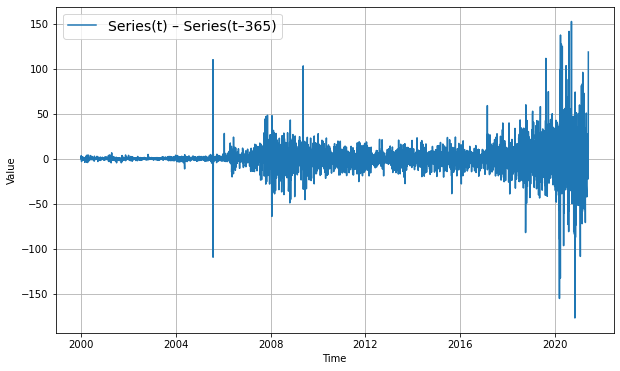

In [104]:
plt.figure(figsize=(10, 6))
plot_series(series2,series3, label="Series(t) – Series(t–365)")
plt.show()

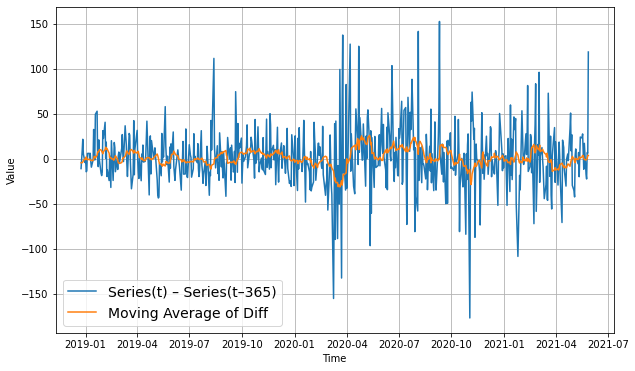

In [108]:
diff_moving_avg = moving_average_forecast(series3, 15)[split_time - 15:]

plt.figure(figsize=(10, 6))
plot_series(time_valid,series3[split_time:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

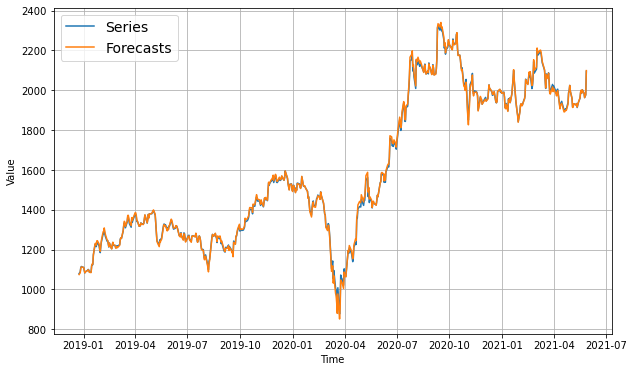

In [111]:
diff_moving_avg_plus_past = series1[split_time:] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [113]:
tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

6.43757762419175

In [114]:
diff_moving_avg_plus_past 

4760    1074.475017
4761    1083.591960
4762    1106.118383
4763    1112.672957
4764    1110.846916
           ...     
5353    1984.216691
5354    1962.560026
5355    1970.323381
5356    1979.663314
5357    2098.533382
Name: Close, Length: 598, dtype: float64